In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

from bbutils import BetaBernoulli, GenerativeModel

In [2]:
k = 10  # Number of classes

# Thetas from provider for each class
theta_provider = np.random.rand(k)/5 + 0.80 
theta_provider[0] = 0.90

# True thetas of blackbox applied to our data. Class 0 has changed
theta_true = theta_provider.copy()
theta_true[0] = 0.80

# Weird average thing for Padhraic
theta_provider_avg  = np.tile(np.mean(theta_provider), k)

In [3]:
# f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
# f.suptitle('Provider vs. True Accuracies')
# ax1.bar(range(k), theta_true)
# ax1.set_ylabel('True')
# ax2.bar(range(k), theta_provider)
# ax2.set_ylabel('Provider')
# ax3.bar(range(k), theta_true - theta_provider)
# ax3.set_ylabel('Difference')

In [4]:
n = 1_000
runs = 1000
pseudo_count = 2

random_strategy_outcome = np.zeros((runs, n))
random_strategy_times_chosen = np.zeros((runs, n))

beta_bernoulli_outcome = np.zeros((runs, n))
beta_bernoulli_times_chosen = np.zeros((runs, n))

alpha = theta_provider * pseudo_count
beta = (1 - theta_provider) * pseudo_count

for r in range(runs):
    generative_model = GenerativeModel(theta_true)
    categories, observations = generative_model.sample(n)

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)

    # Random model
    model = BetaBernoulli(k)

    # Prior
    model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        if category == 0:
            n_success += observation
            total += 1
        model.update(category, observation)
        random_strategy_outcome[r, i] = model._params[0,0] / (model._params[0,0] + model._params[0,1])
        random_strategy_times_chosen[r, i] = total

        
    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # Prior
    model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        theta_hat = model.sample()
        diff = np.abs(theta_hat - theta_provider)
        choices = np.argsort(diff)[::-1]
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        if category == 0:
            n_success += observation
            total += 1
        model.update(category, observation)
        #beta_bernoulli_outcome[i] = n_success / (total + 1e-13)
        beta_bernoulli_outcome[r, i] = model._params[0,0] / (model._params[0,0] + model._params[0,1])
        beta_bernoulli_times_chosen[r, i] = total
        
print(alpha)
print(beta)
print(model._params)

[1.8        1.67306196 1.84258704 1.93259165 1.78468564 1.62532771
 1.98273727 1.63780564 1.80860887 1.82178876]
[0.2        0.32693804 0.15741296 0.06740835 0.21531436 0.37467229
 0.01726273 0.36219436 0.19139113 0.17821124]
[[7.88000000e+01 2.02000000e+01]
 [8.56730620e+01 1.63269380e+01]
 [7.78425870e+01 7.15741296e+00]
 [1.05932592e+02 4.06740835e+00]
 [9.27846856e+01 8.21531436e+00]
 [9.16253277e+01 2.03746723e+01]
 [8.99827373e+01 1.72627284e-02]
 [8.86378056e+01 1.33621944e+01]
 [1.11808609e+02 8.19139113e+00]
 [8.88217888e+01 1.01782112e+01]]


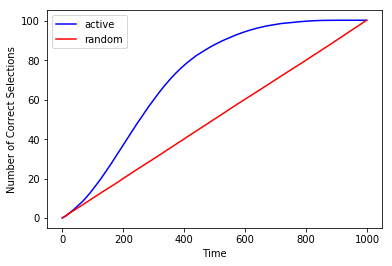

In [5]:
#for i in range(runs):
#    plt.plot(beta_bernoulli_times_chosen[i,:200], c='blue', alpha=0.005)
#    plt.plot(random_strategy_times_chosen[i,:200], c='red', alpha=0.005)
plt.plot(np.mean(beta_bernoulli_times_chosen, axis=0), c='blue', label='active')
plt.plot(np.mean(random_strategy_times_chosen, axis=0), c='red', label='random')
plt.xlabel('Time')
plt.ylabel('Number of Correct Selections')
plt.legend()

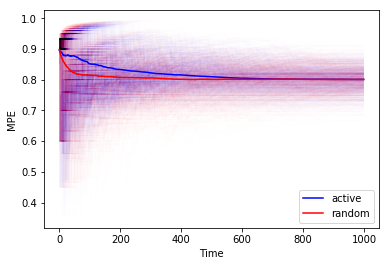

In [6]:
for i in range(runs):
    plt.plot(beta_bernoulli_outcome[i,:], c='blue', alpha=0.005)
    plt.plot(random_strategy_outcome[i,:], c='red', alpha=0.005)
plt.plot(np.mean(beta_bernoulli_outcome, axis=0), c='blue', label='active')
plt.plot(np.mean(random_strategy_outcome, axis=0), c='red', label='random')
plt.xlabel('Time')
plt.ylabel('MPE')
plt.legend()

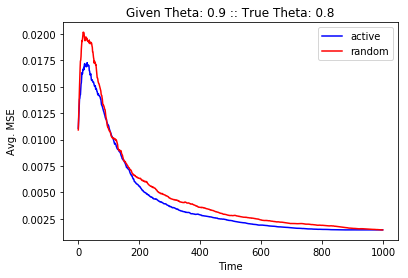

In [7]:
random_mse = (random_strategy_outcome - theta_true[0])**2
active_mse = (beta_bernoulli_outcome - theta_true[0])**2

plt.plot(np.mean(active_mse, axis=0), c='blue', label='active')
plt.plot(np.mean(random_mse, axis=0), c='red', label='random')
plt.title(f'Given Theta: {theta_provider[0]} :: True Theta: {theta_true[0]}')
plt.xlabel('Time')
plt.ylabel('Avg. MSE')
plt.legend()

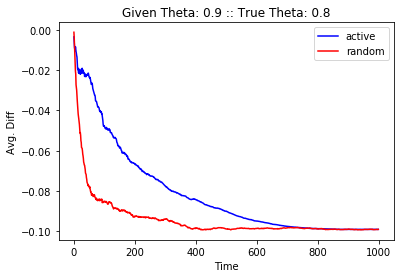

In [8]:
random_diff = np.mean(random_strategy_outcome - theta_provider[0], axis=0)
active_diff = np.mean(beta_bernoulli_outcome - theta_provider[0], axis=0)

plt.plot(active_diff, c='blue', label='active')
plt.plot(random_diff, c='red', label='random')
plt.title(f'Given Theta: {theta_provider[0]} :: True Theta: {theta_true[0]}')
plt.xlabel('Time')
plt.ylabel('Avg. Diff')
plt.legend()